In [9]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### extra trees

In [10]:
def ExtraTreesC(train_x, test_x, train_y, test_y, config):
    
    clf = ExtraTreesClassifier(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def ExtraTreesR(train_x, test_x, train_y, test_y, config):
    
    clf = ExtraTreesRegressor(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def runall_ExtraTreesC(num_set, trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config
        
        result = ExtraTreesC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})

    return table_set
    
    
def runall_ExtraTreesR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = ExtraTreesR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### optuna

In [11]:
def ExtraTrees_creator(train_data, mode, num_valid = 3, label = 'GB') :
    
    def objective(trial) :

        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 900, step = 200),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 32, step = 5),
            'max_depth': trial.suggest_int('max_depth', 3, 21, step = 3)
        }

        result_list = []
        for i in range(num_valid):

            train_x, train_y = label_divide(train_data, None, 'GB', train_only = True)
            train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.25)

            if mode == 'C':
                result = ExtraTreesC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 0.75
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                result_list.append(fscore)

            elif mode == 'R':
                result = ExtraTreesR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)
    
    return objective

## 

### loading training & testing data

In [12]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1928, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1514, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1662, 88)  balance ratio: 0.71
Dimension of dataset 7 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (3150, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2480, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

### search for best hyperparameter

In [13]:
best_paramC, all_scoreC = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = True, 
                                     n_iter = 50, 
                                     filename = 'runhist_array_m2m4_m5_3criteria_ExtraTrees', 
                                     creator = ExtraTrees_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 12:22:52,478] A new study created in memory with name: no-name-deb5979d-bae3-46a2-b436-6a18056fa92b


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:23:39,116] Trial 0 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:25:05,726] Trial 1 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:25:50,050] Trial 2 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:26:59,009] Trial 3 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:28:50,526] Trial 4 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:29:00,665] Trial 5 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:30:44,245] Trial 6 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:30:50,371] Trial 7 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:31:06,865] Trial 8 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:31:53,563] Trial 9 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:32:40,257] Trial 10 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:32:56,538] Trial 11 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:34:38,835] Trial 12 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:35:06,726] Trial 13 failed, because the objective function returned nan.
Precision: 0.8888888888888888 
Recall: 0.34285714285714286 
Aging Rate: 0.0006872502354468399
Precision: 1.0 
Recall: 0.2692307692307692 
Aging Rate: 0.0005345279609030977
Precision: 0.8333333333333334 
Recall: 0.24193548387096775 
Aging Rate: 0.0004581668236312266
[I 2021-12-13 12:36:55,973] Trial 14 finished with value: 0.5046715031935854 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 14 with value: 0.5046715031935854.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:38:38,314] Trial 15 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:39:29,169] Trial 16 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:39:40,381] Trial 17 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:40:11,259] Trial 18 failed, because the objective function returned nan.
Precision: 0.9117647058823529 
Recall: 0.5 
Aging Rate: 0.0008654262224145391
Precision: 0.9545454545454546 
Recall: 0.5454545454545454 
Aging Rate: 0.0011199633466541096
Precision: 0.8333333333333334 
Recall: 0.5932203389830508 
Aging Rate: 0.0010690559218061954
[I 2021-12-13 12:42:24,213] Trial 19 finished with value: 0.7274085592386438 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 19 with value: 0.7274085592386438.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.029411764705882353 
Aging Rate: 5.090742484791407e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:44:08,606] Trial 20 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:44:23,321] Trial 21 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:45:10,541] Trial 22 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.02666666666666667 
Aging Rate: 5.090742484791407e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.5 
Recall: 0.02702702702702703 
Aging Rate: 0.00010181484969582814
[W 2021-12-13 12:46:00,079] Trial 23 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.25 
Aging Rate: 0.0004836205360551837
Precision: 1.0 
Recall: 0.25 
Aging Rate: 0.0004581668236312266
Precision: 1.0 
Recall: 0.16483516483516483 
Aging Rate: 0.0003818056863593555
[I 2021-12-13 12:46:51,279] Trial 24 finished with value: 0.4385487034212247 and parameters: {'n_estimators': 300, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 19 with value: 0.7274085592386438.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:47:07,237] Trial 25 failed, because the objective function returned nan.
Precision: 0.25 
Recall: 0.011904761904761904 
Aging Rate: 0.00010181484969582814
Precision: 1.0 
Recall: 0.024096385542168676 
Aging Rate: 5.090742484791407e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:48:56,312] Trial 26 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:49:14,543] Trial 27 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:50:57,718] Trial 28 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:51:15,955] Trial 29 failed, because the objective function returned nan.
Precision: 0.9629629629629629 
Recall: 0.3466666666666667 
Aging Rate: 0.0006872502354468399
Precision: 1.0 
Recall: 0.29577464788732394 
Aging Rate: 0.0005345279609030977
Precision: 0.8695652173913043 
Recall: 0.29850746268656714 
Aging Rate: 0.0005854353857510118
[I 2021-12-13 12:51:58,008] Trial 30 finished with value: 0.5468557118519859 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 19 with value: 0.7274085592386438.
Precision: 0.9130434782608695 
Recall: 0.2916666666666667 
Aging Rate: 0.0005854353857510118
Precision: 0.9130434782608695 
Recall: 0.27631578947368424 
Aging Rate: 0.0005854353857510118
Precision: 0.896551724137931 
Recall: 0.4262295081967213 
Aging Rate: 0.000738157660294754
[I 2021-12-13 12:52:06,894] Trial 31 finished with value: 0.5524800511329228 and parameters: {'n_estimators': 100, 'm

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:53:05,515] Trial 32 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:53:59,133] Trial 33 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:54:08,388] Trial 34 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:55:20,879] Trial 35 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:55:41,108] Trial 36 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.014285714285714285 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.04477611940298507 
Aging Rate: 7.63611372718711e-05
Precision: 1.0 
Recall: 0.010526315789473684 
Aging Rate: 2.5453712423957035e-05
[I 2021-12-13 12:56:38,717] Trial 37 finished with value: 0.06086990143910178 and parameters: {'n_estimators': 700, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 19 with value: 0.7274085592386438.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:57:39,683] Trial 38 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 12:58:57,057] Trial 39 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.012987012987012988 
Aging Rate: 2.5453712423957035e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.014492753623188406 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-13 12:59:58,687] Trial 40 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:00:15,897] Trial 41 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:00:54,278] Trial 42 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:00:59,237] Trial 43 failed, because the objective function returned nan.
Precision: 0.9090909090909091 
Recall: 0.375 
Aging Rate: 0.0008399725099905821
Precision: 0.9333333333333333 
Recall: 0.2 
Aging Rate: 0.0003818056863593555
Precision: 0.9032258064516129 
Recall: 0.3888888888888889 
Aging Rate: 0.000789065085142668
[I 2021-12-13 13:02:11,923] Trial 44 finished with value: 0.5383828336414543 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 19 with value: 0.7274085592386438.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:03:07,781] Trial 45 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.01282051282051282 
Aging Rate: 2.5453712423957035e-05
Precision: 1.0 
Recall: 0.037037037037037035 
Aging Rate: 7.63611372718711e-05
Precision: 1.0 
Recall: 0.05 
Aging Rate: 0.00010181484969582814
[I 2021-12-13 13:03:28,565] Trial 46 finished with value: 0.08629835281247937 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 12}. Best is trial 19 with value: 0.7274085592386438.
Precision: 1.0 
Recall: 0.26865671641791045 
Aging Rate: 0.0004581668236312266
Precision: 0.7777777777777778 
Recall: 0.19718309859154928 
Aging Rate: 0.0004581668236312266
Precision: 1.0 
Recall: 0.26436781609195403 
Aging Rate: 0.0005854353857510118
[I 2021-12-13 13:04:43,904] Trial 47 finished with value: 0.46072604274421186 and parameters: {'n_estimators': 900, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 19 with valu

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:06:38,679] A new study created in memory with name: no-name-b2ba34a5-c8b3-4b41-a826-ad24bbcf1b71


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:06:38,619] Trial 49 failed, because the objective function returned nan.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9987063389391979 
Recall: 0.9910141206675225 
Aging Rate: 0.5039113428943938
Precision: 0.9987515605493134 
Recall: 0.9913258983890955 
Aging Rate: 0.5221642764015645
Precision: 0.9973924380704041 
Recall: 0.9832904884318766 
Aging Rate: 0.5
[I 2021-12-13 13:06:40,415] Trial 0 finished with value: 0.9947527806036963 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 12}. Best is trial 0 with value: 0.9947527806036963.
Precision: 0.9959404600811907 
Recall: 0.9826435246995995 
Aging Rate: 0.4817470664928292
Precision: 0.9921156373193167 
Recall: 0.9805194805194806 
Aging Rate: 0.49608865710560623
Precision: 0.9920318725099602 
Recall: 0.9816031537450722 
Aging Rate: 0.4908735332464146
[I 2021-12-13 13:06:43,832] Trial 1 finished with value: 0.9890913229407685 and parameters: {'n_estimators': 900, 'min_samples_split': 27, 'max_depth': 18}. Best is trial 0 with value: 0.9947527806036963.
Precision: 0.9617834394904459 
Recall: 0.9355638166047088 
Aging 

Precision: 0.9920739762219286 
Recall: 0.9868593955321945 
Aging Rate: 0.4934810951760104
Precision: 0.9960835509138382 
Recall: 0.9870633893919794 
Aging Rate: 0.49934810951760106
Precision: 0.9947916666666666 
Recall: 0.9896373056994818 
Aging Rate: 0.500651890482399
[I 2021-12-13 13:07:13,346] Trial 17 finished with value: 0.9919792257022458 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 11 with value: 0.9959054793540404.
Precision: 0.9973821989528796 
Recall: 0.983225806451613 
Aging Rate: 0.4980443285528031
Precision: 0.9986910994764397 
Recall: 0.9921976592977894 
Aging Rate: 0.4980443285528031
Precision: 0.9974259974259975 
Recall: 0.9860050890585241 
Aging Rate: 0.5065189048239895
[I 2021-12-13 13:07:15,354] Trial 18 finished with value: 0.9939556632338284 and parameters: {'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 11 with value: 0.9959054793540404.
Precision: 0.9933598937583001 
Recall: 0.98680738

Precision: 0.9960106382978723 
Recall: 0.9894319682959049 
Aging Rate: 0.49022164276401564
Precision: 0.9960369881109643 
Recall: 0.9869109947643979 
Aging Rate: 0.4934810951760104
Precision: 0.9973190348525469 
Recall: 0.9776609724047306 
Aging Rate: 0.4863102998696219
[I 2021-12-13 13:07:48,100] Trial 34 finished with value: 0.9921720773145676 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 11 with value: 0.9959054793540404.
Precision: 0.9960264900662251 
Recall: 0.9947089947089947 
Aging Rate: 0.4921773142112125
Precision: 0.9973509933774835 
Recall: 0.9920948616600791 
Aging Rate: 0.4921773142112125
Precision: 0.9960732984293194 
Recall: 0.9908854166666666 
Aging Rate: 0.4980443285528031
[I 2021-12-13 13:07:51,025] Trial 35 finished with value: 0.9950678622673856 and parameters: {'n_estimators': 700, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 11 with value: 0.9959054793540404.
Precision: 0.996031746031746 
Recall: 0.99340

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:08:22,558] A new study created in memory with name: no-name-1c836d8d-a573-4753-aa65-4a453353ec71


Precision: 0.9945130315500685 
Recall: 0.9863945578231292 
Aging Rate: 0.47522816166883963
[I 2021-12-13 13:08:22,495] Trial 49 finished with value: 0.9934543008996738 and parameters: {'n_estimators': 700, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 11 with value: 0.9959054793540404.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9505813953488372 
Recall: 0.938755980861244 
Aging Rate: 0.49049429657794674
Precision: 0.9558390578999019 
Recall: 0.9365384615384615 
Aging Rate: 0.4843155893536122
Precision: 0.9588235294117647 
Recall: 0.9305423406279734 
Aging Rate: 0.4847908745247148
[I 2021-12-13 13:08:24,296] Trial 0 finished with value: 0.947845455016858 and parameters: {'n_estimators': 500, 'min_samples_split': 22, 'max_depth': 9}. Best is trial 0 with value: 0.947845455016858.
Precision: 0.9864734299516909 
Recall: 0.9912621359223301 
Aging Rate: 0.4919201520912547
Precision: 0.9839857651245552 
Recall: 0.9848619768477292 
Aging Rate: 0.5342205323193916
Precision: 0.9895734597156398 
Recall: 0.9933396764985728 
Aging Rate: 0.501425855513308
[I 2021-12-13 13:08:25,859] Trial 1 finished with value: 0.9878063499073507 and parameters: {'n_estimators': 300, 'min_samples_split': 27, 'max_depth': 18}. Best is trial 1 with value: 0.9878063499073507.
Precision: 0.9851439182915506 
Recall: 0.9915887850467

Precision: 0.7821782178217822 
Recall: 0.6797323135755258 
Aging Rate: 0.4320342205323194
Precision: 0.8073496659242761 
Recall: 0.6865530303030303 
Aging Rate: 0.4268060836501901
Precision: 0.8036677454153183 
Recall: 0.6936685288640596 
Aging Rate: 0.4405893536121673
[I 2021-12-13 13:09:02,546] Trial 17 finished with value: 0.7538157392800473 and parameters: {'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 3}. Best is trial 13 with value: 0.9920984434722485.
Precision: 0.9894837476099426 
Recall: 0.9866539561487131 
Aging Rate: 0.49714828897338403
Precision: 0.9829443447037702 
Recall: 0.9963603275705186 
Aging Rate: 0.529467680608365
Precision: 0.9787234042553191 
Recall: 0.9878618113912232 
Aging Rate: 0.5137832699619772
[I 2021-12-13 13:09:03,410] Trial 18 finished with value: 0.9860630393761709 and parameters: {'n_estimators': 100, 'min_samples_split': 17, 'max_depth': 21}. Best is trial 13 with value: 0.9920984434722485.
Precision: 0.9559686888454012 
Recall: 0.9331423

Precision: 0.9833641404805915 
Recall: 0.994392523364486 
Aging Rate: 0.5142585551330798
Precision: 0.9830348727615457 
Recall: 0.9980861244019139 
Aging Rate: 0.504277566539924
Precision: 0.9853613906678865 
Recall: 0.992626728110599 
Aging Rate: 0.5194866920152091
[I 2021-12-13 13:09:50,747] Trial 34 finished with value: 0.9878904785288215 and parameters: {'n_estimators': 900, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 13 with value: 0.9920984434722485.
Precision: 0.9870490286771508 
Recall: 0.996265172735761 
Aging Rate: 0.5137832699619772
Precision: 0.9898242368177613 
Recall: 0.9953488372093023 
Aging Rate: 0.5137832699619772
Precision: 0.9867172675521821 
Recall: 0.994263862332696 
Aging Rate: 0.5009505703422054
[I 2021-12-13 13:09:54,812] Trial 35 finished with value: 0.9905246513772812 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 13 with value: 0.9920984434722485.
Precision: 0.9815354713313897 
Recall: 0.998023715415

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:10:42,963] A new study created in memory with name: no-name-c4716b3e-0f01-42af-8f90-ffb59e361ac2


Precision: 0.7792349726775957 
Recall: 0.6784015223596574 
Aging Rate: 0.43488593155893535
[I 2021-12-13 13:10:42,914] Trial 49 finished with value: 0.751506826886386 and parameters: {'n_estimators': 900, 'min_samples_split': 27, 'max_depth': 3}. Best is trial 42 with value: 0.9921222153664683.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9271844660194175 
Aging Rate: 0.4580335731414868
Precision: 1.0 
Recall: 0.9321428571428572 
Aging Rate: 0.4694244604316547
Precision: 1.0 
Recall: 0.9112709832134293 
Aging Rate: 0.4556354916067146
[I 2021-12-13 13:10:46,218] Trial 0 finished with value: 0.9710339674921746 and parameters: {'n_estimators': 900, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 0 with value: 0.9710339674921746.
Precision: 1.0 
Recall: 0.9192982456140351 
Aging Rate: 0.4712230215827338
Precision: 1.0 
Recall: 0.9119804400977995 
Aging Rate: 0.447242206235012
Precision: 1.0 
Recall: 0.9003690036900369 
Aging Rate: 0.43884892086330934
[I 2021-12-13 13:10:47,081] Trial 1 finished with value: 0.9658255152332845 and parameters: {'n_estimators': 100, 'min_samples_split': 27, 'max_depth': 9}. Best is trial 0 with value: 0.9710339674921746.
Precision: 1.0 
Recall: 0.8996328029375765 
Aging Rate: 0.44064748201438847
Precision: 1.0 
Recall: 0.9207459207459208 
Aging Rate: 0.4736211

Precision: 1.0 
Recall: 0.9205983889528193 
Aging Rate: 0.47961630695443647
Precision: 1.0 
Recall: 0.9238210399032648 
Aging Rate: 0.4580335731414868
Precision: 1.0 
Recall: 0.9138576779026217 
Aging Rate: 0.43884892086330934
[I 2021-12-13 13:11:26,262] Trial 19 finished with value: 0.9694114577830697 and parameters: {'n_estimators': 100, 'min_samples_split': 22, 'max_depth': 18}. Best is trial 16 with value: 0.9760191296727635.
Precision: 1.0 
Recall: 0.9045893719806763 
Aging Rate: 0.4490407673860911
Precision: 1.0 
Recall: 0.9166666666666666 
Aging Rate: 0.44844124700239807
Precision: 1.0 
Recall: 0.8975 
Aging Rate: 0.4304556354916067
[I 2021-12-13 13:11:27,562] Trial 20 finished with value: 0.9640792252702161 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 12}. Best is trial 16 with value: 0.9760191296727635.
Precision: 1.0 
Recall: 0.9420468557336621 
Aging Rate: 0.4580335731414868
Precision: 1.0 
Recall: 0.9295942720763724 
Aging Rate: 0.467026378896

Precision: 1.0 
Recall: 0.9137529137529138 
Aging Rate: 0.47002398081534774
Precision: 1.0 
Recall: 0.9071680376028202 
Aging Rate: 0.4628297362110312
Precision: 1.0 
Recall: 0.9368295589988082 
Aging Rate: 0.4712230215827338
[I 2021-12-13 13:12:16,650] Trial 38 finished with value: 0.9693023701687163 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 6}. Best is trial 16 with value: 0.9760191296727635.
Precision: 1.0 
Recall: 0.9304029304029304 
Aging Rate: 0.4568345323741007
Precision: 1.0 
Recall: 0.9185905224787363 
Aging Rate: 0.45323741007194246
Precision: 1.0 
Recall: 0.9355608591885441 
Aging Rate: 0.47002398081534774
[I 2021-12-13 13:12:20,062] Trial 39 finished with value: 0.9728875834738355 and parameters: {'n_estimators': 900, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 16 with value: 0.9760191296727635.
Precision: 1.0 
Recall: 0.9186189889025894 
Aging Rate: 0.44664268585131894
Precision: 1.0 
Recall: 0.9402985074626866 
Aging Rate: 0.4

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:12:29,069] A new study created in memory with name: no-name-09b9d9d8-742a-4149-bccd-fa8a29ef309b


Precision: 1.0 
Recall: 0.9464068209500609 
Aging Rate: 0.4658273381294964
[I 2021-12-13 13:12:29,022] Trial 49 finished with value: 0.9762086896091889 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 43 with value: 0.9772132488429704.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9860724233983287 
Recall: 0.944 
Aging Rate: 0.4726793943383805
Precision: 0.9863760217983651 
Recall: 0.9152970922882427 
Aging Rate: 0.48321263989466756
Precision: 0.9870967741935484 
Recall: 0.9598494353826851 
Aging Rate: 0.5102040816326531
[I 2021-12-13 13:12:30,360] Trial 0 finished with value: 0.9690543069784509 and parameters: {'n_estimators': 300, 'min_samples_split': 22, 'max_depth': 9}. Best is trial 0 with value: 0.9690543069784509.
Precision: 0.9891891891891892 
Recall: 0.9432989690721649 
Aging Rate: 0.4871626069782752
Precision: 0.9875862068965517 
Recall: 0.926261319534282 
Aging Rate: 0.4772876892692561
Precision: 0.9887798036465638 
Recall: 0.9501347708894878 
Aging Rate: 0.46938775510204084
[I 2021-12-13 13:12:31,221] Trial 1 finished with value: 0.9704231458540741 and parameters: {'n_estimators': 100, 'min_samples_split': 22, 'max_depth': 9}. Best is trial 1 with value: 0.9704231458540741.
Precision: 0.9446022727272727 
Recall: 0.8962264150943396 
Aging

Precision: 0.9973474801061007 
Recall: 0.9766233766233766 
Aging Rate: 0.49637919684002635
Precision: 0.9947916666666666 
Recall: 0.9732484076433121 
Aging Rate: 0.5055957867017775
[I 2021-12-13 13:13:06,471] Trial 17 finished with value: 0.9891589842089642 and parameters: {'n_estimators': 900, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 16 with value: 0.9895791011966035.
Precision: 0.9986149584487535 
Recall: 0.9730094466936572 
Aging Rate: 0.47531270572745227
Precision: 0.9973404255319149 
Recall: 0.9752925877763329 
Aging Rate: 0.4950625411454905
Precision: 0.9960474308300395 
Recall: 0.9717223650385605 
Aging Rate: 0.49967083607636603
[I 2021-12-13 13:13:09,875] Trial 18 finished with value: 0.9885612795749563 and parameters: {'n_estimators': 900, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 16 with value: 0.9895791011966035.
Precision: 0.9972413793103448 
Recall: 0.9704697986577181 
Aging Rate: 0.4772876892692561
Precision: 1.0 
Recall: 0.9713168187744459 
A

Precision: 0.9973509933774835 
Recall: 0.9881889763779528 
Aging Rate: 0.4970375246872943
[I 2021-12-13 13:13:58,778] Trial 34 finished with value: 0.9909315955430044 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 34 with value: 0.9909315955430044.
Precision: 0.9946666666666667 
Recall: 0.9841688654353562 
Aging Rate: 0.4937458854509546
Precision: 0.9986772486772487 
Recall: 0.9817945383615084 
Aging Rate: 0.4976958525345622
Precision: 1.0 
Recall: 0.9798927613941019 
Aging Rate: 0.48123765635286375
[I 2021-12-13 13:14:00,906] Trial 35 finished with value: 0.9920205943662813 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 35 with value: 0.9920205943662813.
Precision: 0.9959623149394348 
Recall: 0.9827357237715804 
Aging Rate: 0.489137590520079
Precision: 1.0 
Recall: 0.9865771812080537 
Aging Rate: 0.4838709677419355
Precision: 0.9944598337950139 
Recall: 0.9835616438356164 
Aging Rate: 0.47531

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:14:35,972] A new study created in memory with name: no-name-9fc5b7b4-5d32-4e03-b39a-457ef3d0fb99


Precision: 0.9920424403183024 
Recall: 0.9816272965879265 
Aging Rate: 0.49637919684002635
[I 2021-12-13 13:14:35,910] Trial 49 finished with value: 0.9899130847584404 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 47 with value: 0.9929943066874974.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9973226238286479 
Recall: 0.9959893048128342 
Aging Rate: 0.49306930693069306
Precision: 0.997364953886693 
Recall: 0.9934383202099738 
Aging Rate: 0.500990099009901
Precision: 0.9959514170040485 
Recall: 0.9879518072289156 
Aging Rate: 0.4891089108910891
[I 2021-12-13 13:14:39,345] Trial 0 finished with value: 0.9952822299342338 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 0 with value: 0.9952822299342338.
Precision: 0.9375 
Recall: 0.896414342629482 
Aging Rate: 0.4752475247524752
Precision: 0.9625 
Recall: 0.9203187250996016 
Aging Rate: 0.4752475247524752
Precision: 0.9368279569892473 
Recall: 0.9280958721704394 
Aging Rate: 0.4910891089108911
[I 2021-12-13 13:14:41,564] Trial 1 finished with value: 0.9342748066501046 and parameters: {'n_estimators': 700, 'min_samples_split': 12, 'max_depth': 6}. Best is trial 0 with value: 0.9952822299342338.
Precision: 0.8698727015558698 
Recall: 0.8167330677290837 
Aging Rate: 0.46666

Precision: 0.8867403314917127 
Recall: 0.834850455136541 
Aging Rate: 0.4778877887788779
Precision: 0.8799454297407913 
Recall: 0.8509234828496042 
Aging Rate: 0.48382838283828383
Precision: 0.8716875871687587 
Recall: 0.8085381630012937 
Aging Rate: 0.47326732673267324
[I 2021-12-13 13:15:14,542] Trial 17 finished with value: 0.8614846300152993 and parameters: {'n_estimators': 500, 'min_samples_split': 27, 'max_depth': 3}. Best is trial 13 with value: 0.9961453326744664.
Precision: 0.9931412894375857 
Recall: 0.9877216916780355 
Aging Rate: 0.48118811881188117
Precision: 0.9934296977660972 
Recall: 0.9908256880733946 
Aging Rate: 0.5023102310231023
Precision: 0.9946808510638298 
Recall: 0.990728476821192 
Aging Rate: 0.49636963696369635
[I 2021-12-13 13:15:16,440] Trial 18 finished with value: 0.9923094813414984 and parameters: {'n_estimators': 500, 'min_samples_split': 7, 'max_depth': 15}. Best is trial 13 with value: 0.9961453326744664.
Precision: 0.9855263157894737 
Recall: 0.96645

Precision: 0.8993006993006993 
Recall: 0.8383311603650587 
Aging Rate: 0.47194719471947194
Precision: 0.8893557422969187 
Recall: 0.8455392809587217 
Aging Rate: 0.47128712871287126
Precision: 0.9154518950437318 
Recall: 0.8061617458279846 
Aging Rate: 0.4528052805280528
[I 2021-12-13 13:15:57,603] Trial 34 finished with value: 0.8740923231624631 and parameters: {'n_estimators': 900, 'min_samples_split': 27, 'max_depth': 3}. Best is trial 23 with value: 0.9965058233148252.
Precision: 0.9933155080213903 
Recall: 0.9919893190921228 
Aging Rate: 0.49372937293729374
Precision: 0.9973118279569892 
Recall: 0.9973118279569892 
Aging Rate: 0.4910891089108911
Precision: 0.9972677595628415 
Recall: 0.989159891598916 
Aging Rate: 0.48316831683168315
[I 2021-12-13 13:16:00,515] Trial 35 finished with value: 0.994827719967781 and parameters: {'n_estimators': 700, 'min_samples_split': 7, 'max_depth': 15}. Best is trial 23 with value: 0.9965058233148252.
Precision: 0.9961734693877551 
Recall: 0.99617

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:16:32,390] A new study created in memory with name: no-name-fccba0fc-6231-48db-ba73-4565991670fc


Precision: 0.997289972899729 
Recall: 0.9865951742627346 
Aging Rate: 0.4871287128712871
[I 2021-12-13 13:16:32,218] Trial 49 finished with value: 0.9942441207108121 and parameters: {'n_estimators': 700, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 23 with value: 0.9965058233148252.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9518518518518518 
Recall: 0.9799809342230696 
Aging Rate: 0.5943863511282333
Precision: 0.94375 
Recall: 0.970615243342516 
Aging Rate: 0.616400660429279
Precision: 0.9356943150046598 
Recall: 0.9776046738072055 
Aging Rate: 0.5905338470005503
[I 2021-12-13 13:16:38,006] Trial 0 finished with value: 0.9551334612431539 and parameters: {'n_estimators': 900, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 0 with value: 0.9551334612431539.
Precision: 0.9830985915492958 
Recall: 0.9961941008563273 
Aging Rate: 0.5861309851403412
Precision: 0.9758588672237697 
Recall: 0.9933837429111532 
Aging Rate: 0.592735277930655
Precision: 0.9780018331805683 
Recall: 0.994408201304753 
Aging Rate: 0.600440286186021
[I 2021-12-13 13:16:40,377] Trial 1 finished with value: 0.9845715488309316 and parameters: {'n_estimators': 500, 'min_samples_split': 27, 'max_depth': 21}. Best is trial 1 with value: 0.9845715488309316.
Precision: 0.6229508196721312 
Recall: 0.9922630560928434 
Aging Ra

Precision: 0.986449864498645 
Recall: 0.9909255898366606 
Aging Rate: 0.6092460099064392
Precision: 0.9837631327602674 
Recall: 0.9970958373668926 
Aging Rate: 0.5762245459548707
Precision: 0.9868791002811621 
Recall: 0.9971590909090909 
Aging Rate: 0.5872317006053935
[I 2021-12-13 13:17:20,036] Trial 17 finished with value: 0.9890444936659316 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 16 with value: 0.9914632411867442.
Precision: 0.974025974025974 
Recall: 0.995260663507109 
Aging Rate: 0.593285635663181
Precision: 0.9765037593984962 
Recall: 0.9923591212989494 
Aging Rate: 0.5855806274078151
Precision: 0.9787234042553191 
Recall: 0.9952963311382879 
Aging Rate: 0.5949367088607594
[I 2021-12-13 13:17:20,891] Trial 18 finished with value: 0.9827813159882824 and parameters: {'n_estimators': 100, 'min_samples_split': 17, 'max_depth': 18}. Best is trial 16 with value: 0.9914632411867442.
Precision: 0.9745283018867924 
Recall: 0.9913627639

Precision: 0.9863760217983651 
Recall: 0.9945054945054945 
Aging Rate: 0.6059438635112824
Precision: 0.9851162790697674 
Recall: 0.9943661971830986 
Aging Rate: 0.5916345624656026
Precision: 0.9793233082706767 
Recall: 0.9942748091603053 
Aging Rate: 0.5855806274078151
[I 2021-12-13 13:17:57,706] Trial 34 finished with value: 0.987455799561658 and parameters: {'n_estimators': 700, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 16 with value: 0.9914632411867442.
Precision: 0.9842738205365402 
Recall: 0.9953227315247896 
Aging Rate: 0.5949367088607594
Precision: 0.9835013748854262 
Recall: 0.998139534883721 
Aging Rate: 0.600440286186021
Precision: 0.9839924670433146 
Recall: 0.996186844613918 
Aging Rate: 0.5844799119427628
[I 2021-12-13 13:18:01,302] Trial 35 finished with value: 0.9884307811129012 and parameters: {'n_estimators': 900, 'min_samples_split': 22, 'max_depth': 21}. Best is trial 16 with value: 0.9914632411867442.
Precision: 0.9860205032618826 
Recall: 0.995296331

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:18:19,989] A new study created in memory with name: no-name-2fa53ab8-8287-40f4-991f-0a2d6d17128e


Precision: 0.9830827067669173 
Recall: 0.990530303030303 
Aging Rate: 0.5855806274078151
[I 2021-12-13 13:18:19,942] Trial 49 finished with value: 0.9871332290408644 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 16 with value: 0.9914632411867442.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.8952254641909815 
Aging Rate: 0.4440789473684211
Precision: 1.0 
Recall: 0.8817345597897503 
Aging Rate: 0.44144736842105264
Precision: 1.0 
Recall: 0.8865979381443299 
Aging Rate: 0.45263157894736844
[I 2021-12-13 13:18:22,967] Trial 0 finished with value: 0.9564961878975922 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 6}. Best is trial 0 with value: 0.9564961878975922.
Precision: 1.0 
Recall: 0.8890322580645161 
Aging Rate: 0.4532894736842105
Precision: 1.0 
Recall: 0.8993377483443709 
Aging Rate: 0.44671052631578945
Precision: 1.0 
Recall: 0.8958333333333334 
Aging Rate: 0.45263157894736844
[I 2021-12-13 13:18:24,719] Trial 1 finished with value: 0.9593617498048248 and parameters: {'n_estimators': 500, 'min_samples_split': 27, 'max_depth': 6}. Best is trial 1 with value: 0.9593617498048248.
Precision: 1.0 
Recall: 0.87716955941255 
Aging Rate: 0.43223684210526314
Precision: 1.0 
Recall: 0.9029374201787995 
Aging Rate: 0.4651315

Precision: 1.0 
Recall: 0.9153846153846154 
Aging Rate: 0.4697368421052632
Precision: 1.0 
Recall: 0.9295426452410384 
Aging Rate: 0.49473684210526314
Precision: 1.0 
Recall: 0.9306666666666666 
Aging Rate: 0.45921052631578946
[I 2021-12-13 13:18:56,369] Trial 19 finished with value: 0.971704333031492 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 12 with value: 0.9740064909495681.
Precision: 1.0 
Recall: 0.9009247027741083 
Aging Rate: 0.4486842105263158
Precision: 1.0 
Recall: 0.9111389236545682 
Aging Rate: 0.4789473684210526
Precision: 1.0 
Recall: 0.8978288633461047 
Aging Rate: 0.4625
[I 2021-12-13 13:18:57,650] Trial 20 finished with value: 0.9628813939284151 and parameters: {'n_estimators': 300, 'min_samples_split': 7, 'max_depth': 3}. Best is trial 12 with value: 0.9740064909495681.
Precision: 1.0 
Recall: 0.9155495978552279 
Aging Rate: 0.4493421052631579
Precision: 1.0 
Recall: 0.9119170984455959 
Aging Rate: 0.4631578947368421


Precision: 1.0 
Recall: 0.908256880733945 
Aging Rate: 0.45592105263157895
Precision: 1.0 
Recall: 0.9128686327077749 
Aging Rate: 0.44802631578947366
Precision: 1.0 
Recall: 0.9010416666666666 
Aging Rate: 0.45526315789473687
[I 2021-12-13 13:19:31,812] Trial 38 finished with value: 0.9645529037911414 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 35 with value: 0.9776916057283653.
Precision: 1.0 
Recall: 0.9200507614213198 
Aging Rate: 0.4769736842105263
Precision: 1.0 
Recall: 0.9043478260869565 
Aging Rate: 0.4789473684210526
Precision: 1.0 
Recall: 0.9125475285171103 
Aging Rate: 0.47368421052631576
[I 2021-12-13 13:19:34,252] Trial 39 finished with value: 0.9665454904077411 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 35 with value: 0.9776916057283653.
Precision: 1.0 
Recall: 0.9249329758713136 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.9352791878172588 
Aging Rate: 0.4

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:19:50,653] A new study created in memory with name: no-name-a0be2d1f-73cb-43e6-8c13-cfd6ff27ab84


Precision: 1.0 
Recall: 0.9281045751633987 
Aging Rate: 0.46710526315789475
[I 2021-12-13 13:19:50,606] Trial 49 finished with value: 0.9730557266498773 and parameters: {'n_estimators': 300, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 35 with value: 0.9776916057283653.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9838492597577388 
Recall: 0.9518229166666666 
Aging Rate: 0.4888157894736842
Precision: 0.9944367176634215 
Recall: 0.9285714285714286 
Aging Rate: 0.4730263157894737
Precision: 0.9873060648801129 
Recall: 0.9271523178807947 
Aging Rate: 0.4664473684210526
[I 2021-12-13 13:19:52,386] Trial 0 finished with value: 0.9688407018902581 and parameters: {'n_estimators': 500, 'min_samples_split': 32, 'max_depth': 9}. Best is trial 0 with value: 0.9688407018902581.
Precision: 1.0 
Recall: 0.9811320754716981 
Aging Rate: 0.4789473684210526
Precision: 0.9986449864498645 
Recall: 0.9722955145118733 
Aging Rate: 0.4855263157894737
Precision: 0.9986357435197817 
Recall: 0.973404255319149 
Aging Rate: 0.48223684210526313
[I 2021-12-13 13:19:54,142] Trial 1 finished with value: 0.9905079597808566 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 1 with value: 0.9905079597808566.
Precision: 0.9158878504672897 
Recall: 0.8886010362694301 
Aging R

Precision: 0.9986648865153538 
Recall: 0.9676584734799483 
Aging Rate: 0.49276315789473685
[I 2021-12-13 13:20:19,162] Trial 17 finished with value: 0.9858739170543652 and parameters: {'n_estimators': 300, 'min_samples_split': 22, 'max_depth': 15}. Best is trial 15 with value: 0.9914642978136451.
Precision: 0.9986486486486487 
Recall: 0.9723684210526315 
Aging Rate: 0.4868421052631579
Precision: 0.997229916897507 
Recall: 0.9664429530201343 
Aging Rate: 0.475
Precision: 1.0 
Recall: 0.964095744680851 
Aging Rate: 0.4769736842105263
[I 2021-12-13 13:20:20,002] Trial 18 finished with value: 0.9872397912838627 and parameters: {'n_estimators': 100, 'min_samples_split': 17, 'max_depth': 21}. Best is trial 15 with value: 0.9914642978136451.
Precision: 0.8092715231788079 
Recall: 0.8335607094133697 
Aging Rate: 0.4967105263157895
Precision: 0.836241610738255 
Recall: 0.8186596583442839 
Aging Rate: 0.4901315789473684
Precision: 0.8448979591836735 
Recall: 0.7992277992277992 
Aging Rate: 0.483

Precision: 1.0 
Recall: 0.9790575916230366 
Aging Rate: 0.4921052631578947
Precision: 0.998639455782313 
Recall: 0.9865591397849462 
Aging Rate: 0.48355263157894735
Precision: 0.9986244841815681 
Recall: 0.9705882352941176 
Aging Rate: 0.47828947368421054
[I 2021-12-13 13:20:43,382] Trial 35 finished with value: 0.9916538953548407 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 23 with value: 0.9925770862270737.
Precision: 0.996005326231691 
Recall: 0.9739583333333334 
Aging Rate: 0.49407894736842106
Precision: 0.9973262032085561 
Recall: 0.9933422103861518 
Aging Rate: 0.4921052631578947
Precision: 0.994579945799458 
Recall: 0.9734748010610079 
Aging Rate: 0.4855263157894737
[I 2021-12-13 13:20:44,690] Trial 36 finished with value: 0.9902400434452564 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 23 with value: 0.9925770862270737.
Precision: 1.0 
Recall: 0.9725848563968669 
Aging Rate: 0.4901

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 13:21:07,432] A new study created in memory with name: no-name-7abc19a0-102a-4d1c-8eb2-5a10b083ed01


Precision: 0.9878048780487805 
Recall: 0.943078913324709 
Aging Rate: 0.4855263157894737
[I 2021-12-13 13:21:07,385] Trial 49 finished with value: 0.9725736928386918 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 9}. Best is trial 41 with value: 0.9936917724154083.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.38461538461538464 
Aging Rate: 0.03588516746411483
Precision: 0.972972972972973 
Recall: 0.391304347826087 
Aging Rate: 0.04425837320574163
Precision: 1.0 
Recall: 0.40476190476190477 
Aging Rate: 0.04066985645933014
[I 2021-12-13 13:21:10,407] Trial 0 finished with value: 0.6407222457483415 and parameters: {'n_estimators': 900, 'min_samples_split': 27, 'max_depth': 18}. Best is trial 0 with value: 0.6407222457483415.
Precision: 1.0 
Recall: 0.05 
Aging Rate: 0.005980861244019139
Precision: 1.0 
Recall: 0.08 
Aging Rate: 0.007177033492822967
Precision: 1.0 
Recall: 0.07575757575757576 
Aging Rate: 0.005980861244019139
[I 2021-12-13 13:21:12,514] Trial 1 finished with value: 0.1691878300812872 and parameters: {'n_estimators': 700, 'min_samples_split': 17, 'max_depth': 6}. Best is trial 0 with value: 0.6407222457483415.
Precision: 0.9444444444444444 
Recall: 0.2328767123287671 
Aging Rate: 0.0215311004784689
Precision: 1.0 
Recall: 0.25 
Aging Rate: 0.0239234449

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:21:23,599] Trial 7 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.027777777777777776 
Aging Rate: 0.0023923444976076554
Precision: 0.7142857142857143 
Recall: 0.0684931506849315 
Aging Rate: 0.008373205741626795
Precision: 1.0 
Recall: 0.07042253521126761 
Aging Rate: 0.005980861244019139
[I 2021-12-13 13:21:24,888] Trial 8 finished with value: 0.1366435831373918 and parameters: {'n_estimators': 300, 'min_samples_split': 32, 'max_depth': 6}. Best is trial 0 with value: 0.6407222457483415.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:21:26,171] Trial 9 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.7936507936507936 
Aging Rate: 0.05980861244019139
Precision: 0.9807692307692307 
Recall: 0.796875 
Aging Rate: 0.06220095693779904
Precision: 0.9814814814814815 
Recall: 0.7361111111111112 
Aging Rate: 0.0645933014354067
[I 2021-12-13 13:21:28,383] Trial 10 finished with value: 0.8987578810964113 and parameters: {'n_estimators': 700, 'min_samples_split': 7, 'max_depth': 18}. Best is trial 10 with value: 0.8987578810964113.
Precision: 0.9090909090909091 
Recall: 0.15151515151515152 
Aging Rate: 0.013157894736842105
Precision: 1.0 
Recall: 0.15853658536585366 
Aging Rate: 0.01555023923444976
Precision: 0.9090909090909091 
Recall: 0.11764705882352941 
Aging Rate: 0.013157894736842105
[I 2021-12-13 13:21:29,205] Trial 11 finished with value: 0.311300645247708 and parameters: {'n_estimators': 100, 'min_samples_split': 32, 'max_depth': 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:21:51,532] Trial 21 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.47435897435897434 
Aging Rate: 0.04425837320574163
Precision: 0.9545454545454546 
Recall: 0.5185185185185185 
Aging Rate: 0.05263157894736842
Precision: 0.96 
Recall: 0.6075949367088608 
Aging Rate: 0.05980861244019139
[I 2021-12-13 13:21:53,752] Trial 22 finished with value: 0.7472474321322197 and parameters: {'n_estimators': 700, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 10 with value: 0.8987578810964113.
Precision: 0.972972972972973 
Recall: 0.8571428571428571 
Aging Rate: 0.08851674641148326
Precision: 0.9833333333333333 
Recall: 0.8309859154929577 
Aging Rate: 0.07177033492822966
Precision: 1.0 
Recall: 0.7727272727272727 
Aging Rate: 0.08133971291866028
[I 2021-12-13 13:21:56,762] Trial 23 finished with value: 0.918180634300986 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 21}. Be

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:22:08,153] Trial 27 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:22:10,050] Trial 28 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.7439024390243902 
Aging Rate: 0.0729665071770335
Precision: 1.0 
Recall: 0.8507462686567164 
Aging Rate: 0.06818181818181818
Precision: 1.0 
Recall: 0.8461538461538461 
Aging Rate: 0.06578947368421052
[I 2021-12-13 13:22:13,063] Trial 29 finished with value: 0.9229640780813181 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 29 with value: 0.9229640780813181.
Precision: 1.0 
Recall: 0.8507462686567164 
Aging Rate: 0.06818181818181818
Precision: 0.9818181818181818 
Recall: 0.8059701492537313 
Aging Rate: 0.06578947368421052
Precision: 0.96875 
Recall: 0.8266666666666667 
Aging Rate: 0.07655502392344497
[I 2021-12-13 13:22:16,079] Trial 30 finished with value: 0.9210707794317177 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 29 with value: 0

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:22:17,830] Trial 31 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.7272727272727273 
Aging Rate: 0.06698564593301436
Precision: 0.9622641509433962 
Recall: 0.5795454545454546 
Aging Rate: 0.06339712918660287
Precision: 1.0 
Recall: 0.8 
Aging Rate: 0.07177033492822966
[I 2021-12-13 13:22:20,838] Trial 32 finished with value: 0.8586424952577537 and parameters: {'n_estimators': 900, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 29 with value: 0.9229640780813181.
Precision: 1.0 
Recall: 0.796875 
Aging Rate: 0.061004784688995214
Precision: 1.0 
Recall: 0.84 
Aging Rate: 0.07535885167464115
Precision: 0.9833333333333333 
Recall: 0.7866666666666666 
Aging Rate: 0.07177033492822966
[I 2021-12-13 13:22:23,739] Trial 33 finished with value: 0.9179726085500971 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 29 with value: 0.9229640780813181.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:22:25,492] Trial 34 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.8076923076923077 
Aging Rate: 0.07535885167464115
Precision: 0.9696969696969697 
Recall: 0.8311688311688312 
Aging Rate: 0.07894736842105263
Precision: 1.0 
Recall: 0.7021276595744681 
Aging Rate: 0.07894736842105263
[I 2021-12-13 13:22:27,725] Trial 35 finished with value: 0.9011229933308508 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 29 with value: 0.9229640780813181.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:22:29,007] Trial 36 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.8205128205128205 
Aging Rate: 0.07655502392344497
Precision: 0.9473684210526315 
Recall: 0.8571428571428571 
Aging Rate: 0.06818181818181818
Precision: 1.0 
Recall: 0.8048780487804879 
Aging Rate: 0.07894736842105263
[I 2021-12-13 13:22:32,020] Trial 37 finished with value: 0.9198367291294449 and parameters: {'n_estimators': 900, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 29 with value: 0.9229640780813181.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:22:33,290] Trial 38 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.8169014084507042 
Aging Rate: 0.06937799043062201
Precision: 1.0 
Recall: 0.8271604938271605 
Aging Rate: 0.08014354066985646
Precision: 1.0 
Recall: 0.7727272727272727 
Aging Rate: 0.061004784688995214
[I 2021-12-13 13:22:35,053] Trial 39 finished with value: 0.919876407181266 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 29 with value: 0.9229640780813181.
Precision: 1.0 
Recall: 0.8148148148148148 
Aging Rate: 0.07894736842105263
Precision: 0.967741935483871 
Recall: 0.8 
Aging Rate: 0.07416267942583732
Precision: 0.9836065573770492 
Recall: 0.7058823529411765 
Aging Rate: 0.0729665071770335
[I 2021-12-13 13:22:36,804] Trial 40 finished with value: 0.8952545306827311 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 29 with value: 0.9229

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:22:37,630] Trial 41 failed, because the objective function returned nan.
Precision: 0.9818181818181818 
Recall: 0.6923076923076923 
Aging Rate: 0.06578947368421052
Precision: 0.9838709677419355 
Recall: 0.8026315789473685 
Aging Rate: 0.07416267942583732
Precision: 0.9642857142857143 
Recall: 0.7105263157894737 
Aging Rate: 0.06698564593301436
[I 2021-12-13 13:22:38,919] Trial 42 finished with value: 0.8725617013288055 and parameters: {'n_estimators': 300, 'min_samples_split': 7, 'max_depth': 21}. Best is trial 29 with value: 0.9229640780813181.
Precision: 1.0 
Recall: 0.8088235294117647 
Aging Rate: 0.06578947368421052
Precision: 0.9821428571428571 
Recall: 0.859375 
Aging Rate: 0.06698564593301436
Precision: 1.0 
Recall: 0.9027777777777778 
Aging Rate: 0.07775119617224881
[I 2021-12-13 13:22:41,143] Trial 43 finished with value: 0.9394542518083487 and parameters: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': 21}

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:22:44,660] Trial 45 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 13:22:46,420] Trial 46 failed, because the objective function returned nan.
Precision: 1.0 
Recall: 0.6984126984126984 
Aging Rate: 0.05263157894736842
Precision: 1.0 
Recall: 0.8064516129032258 
Aging Rate: 0.05980861244019139
Precision: 0.9807692307692307 
Recall: 0.7183098591549296 
Aging Rate: 0.06220095693779904
[I 2021-12-13 13:22:48,180] Trial 47 finished with value: 0.8842296189185657 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 21}. Best is trial 43 with value: 0.9394542518083487.
Precision: 0.9666666666666667 
Recall: 0.4084507042253521 
Aging Rate: 0.03588516746411483
Precision: 1.0 
Recall: 0.5324675324675324 
Aging Rate: 0.04904306220095694
Precision: 0.9743589743589743 
Recall: 0.5205479452054794 
Aging Rate: 0.04665071770334928
[I 2021-12-13 13:22:49,003] Trial 48 finished with value: 0.7164433732430516 and parameters: {'n_estimators': 100, 'min_samples_split': 22, 'max_depth': 21}. B

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 50,
                                     filename = 'runhist_array_m2m5_4selection_ExtraTrees', 
                                     creator = ExtraTrees_creator
                                    )

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 4, num_col = 3, model = 'ExtraTrees Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

## 

### Classifier


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 4.111081419967522e-05

 Dataset 1:
Precision: 0.0005431830526887561 
Recall: 0.0196078431372549 
Aging Rate: 0.03784250447080104

 Dataset 2:
Precision: 0.001153846153846154 
Recall: 0.23529411764705882 
Aging Rate: 0.21377623383831118

 Dataset 3:
Precision: 0.003355704697986577 
Recall: 0.0392156862745098 
Aging Rate: 0.012251022631503216

 Dataset 4:
Precision: 0.0011494252873563218 
Recall: 0.0196078431372549 
Aging Rate: 0.017883204176858722

 Dataset 5:
Precision: 0.0011402508551881414 
Recall: 0.058823529411764705 
Aging Rate: 0.05408127607967276

 Dataset 6:
Precision: 0.0013050570962479609 
Recall: 0.47058823529411764 
Aging Rate: 0.3780139365660137

 Dataset 7:
Precision: 0.0014641288433382138 
Recall: 0.0196078431372549 
Aging Rate: 0.01403934304918909

 Dataset 8:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010216037328619294

 Dataset 9:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.033813644679232875


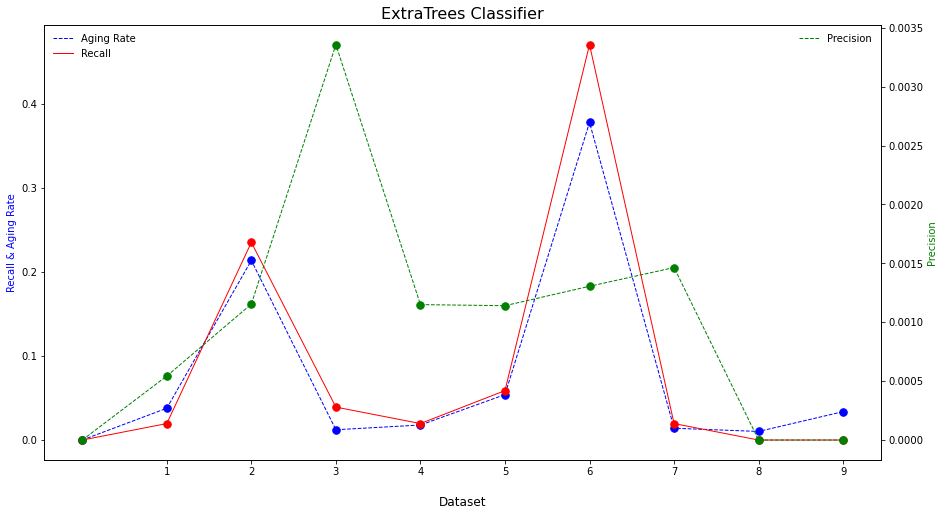

In [14]:
table_setC = runall_ExtraTreesC(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'ExtraTrees Classifier')

In [15]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,515.934211,156844.0,304.0,0.0,2.0,51.0,48596.0,0.000000,0.000000,0.000041,0.000000,0.000000
dataset 1,1.000000,3067.0,3067.0,1.0,1840.0,50.0,46758.0,0.000543,0.019608,0.037843,0.518143,0.000000
dataset 2,1.000000,4207.0,4207.0,12.0,10388.0,39.0,38210.0,0.001154,0.235294,0.213776,1.100656,0.174647
dataset 3,1.000000,3336.0,3336.0,2.0,594.0,49.0,48004.0,0.003356,0.039216,0.012251,3.201013,0.056287
dataset 4,1.000000,3038.0,3038.0,1.0,869.0,50.0,47729.0,0.001149,0.019608,0.017883,1.096439,0.014515
dataset 5,1.006623,3040.0,3020.0,3.0,2628.0,48.0,45970.0,0.001140,0.058824,0.054081,1.087688,0.043297
dataset 6,0.719016,3040.0,4228.0,24.0,18366.0,27.0,30232.0,0.001305,0.470588,0.378014,1.244897,0.380546
dataset 7,1.000000,3040.0,3040.0,1.0,682.0,50.0,47916.0,0.001464,0.019608,0.014039,1.396635,0.017139
dataset 8,1.000000,3040.0,3040.0,0.0,497.0,51.0,48101.0,0.000000,0.000000,0.010216,0.000000,0.000000
dataset 9,10.000000,3040.0,304.0,0.0,1645.0,51.0,46953.0,0.000000,0.000000,0.033814,0.000000,0.000000


### Regressor

In [ ]:
pr_dict, table_setR = runall_ExtraTreesR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                         thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'ExtraTrees Regressor')

In [ ]:
multiple_curve(3, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### export

In [16]:
savedate = '20211214'
TPE_multi = True

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'ExtraTrees'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'ExtraTrees')